# Assignment 5: Poisson Matrix Factorization


STATS305C, Stanford University, Spring 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw5/hw5.ipynb)

---

**Name:**

**Collaborators:**

---

# Background

**Poisson matrix factorization** (PMF) is a mixed membership model like LDA, and it has close ties to non-negative factorization of count matrices. Let $\mathbf{X} \in \mathbb{N}^{N \times M}$ denote a count matrix with entries $x_{n,m}$. We model each entry as a Poisson random variable,
\begin{align}
x_{n,m} &\sim \mathrm{Po}\Big(\boldsymbol{\theta}_{n}^\top \boldsymbol{\eta}_{m} \Big)
= \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \eta_{m,k} \Big),
\end{align}
where $\boldsymbol{\theta}_{n} \in \mathbb{R}_+^K$ and $\boldsymbol{\eta}_{n} \in \mathbb{R}_+^K$ are _non-negative_ feature vectors for row $n$ and column $m$, respectively. 

PMF has been used for recommender systems, aka collaborative filtering. In a recommender system, the rows correspond to users, the columns to items, and the entries $x_{n,m}$ to how much user $n$ liked item $m$ (on a scale of $0,1,2,\ldots$ stars, for example). The $K$ feature dimensions capture different aspects of items that users may weight in their ratings.

Note that the Poisson rate must be non-negative. It is sufficient to ensure $\boldsymbol{\theta}_{n}$ and $\boldsymbol{\eta}_{m}$ are non-negative. To that end, PMF uses gamma priors,
\begin{align}
\theta_{n,k} &\sim \mathrm{Ga}(\alpha_\theta, \beta_\theta) \\
\eta_{m,k} &\sim \mathrm{Ga}(\alpha_\eta, \beta_\eta),
\end{align}
where $\alpha_\star$ and $\beta_\star$ are hyperparameters. When $\alpha_\star < 1$, the gamma distribution has a sharp peak at zero and the prior induces sparsity in the feature vectors.

## Latent variable formulation
PMF can be rewritten in terms of a latent variable model. Note that,
\begin{align}
x_{n,m} \sim \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \eta_{m,k} \Big)
\iff x_{n,m} &= \sum_{k=1}^K z_{n,m,k} \\
z_{n,m,k} &\sim \mathrm{Po}(\theta_{nk} \eta_{mk}) \quad \text{independently}.
\end{align}
From this perspective, a user's rating of an item is a sum of ratings along each feature dimension, and each feature rating is an independent Poisson random variable. 

The joint distribution is,
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\Theta}, \mathbf{H}) 
= 
\left[\prod_{n=1}^N \prod_{m=1}^M \mathbb{I}\Big[x_{n,m}=\sum_{k=1}^K z_{n,m,k} \Big] 
\prod_{k=1}^K \mathrm{Po}(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) 
\right] 
\times \left[ \prod_{n=1}^N \prod_{k=1}^K \mathrm{Ga}(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \right]
\times \left[ \prod_{m=1}^M \prod_{k=1}^K \mathrm{Ga}(\eta_{m,k} \mid \alpha_\eta, \beta_\eta) \right]
\end{align}
where $\mathbf{Z} \in \mathbb{N}^{N\times M \times K}$ denotes the _tensor_ of feature ratings, $\boldsymbol{\Theta} \in \mathbb{R}_+^{N \times K}$ is a matrix with rows $\boldsymbol{\theta}_n$, and $\mathbf{H} \in \mathbb{R}_+^{M \times K}$ is a matrix with rows $\boldsymbol{\eta}_m$. 

In [ ]:
import torch
from torch.distributions import Distribution, Gamma, Poisson, Multinomial
from torch.distributions.kl import kl_divergence

from tqdm.auto import trange

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

# Problem 1: Conditional distributions [math]

Since this model is constructed from conjugate exponential family distributions, the conditionals are available in closed form. We will let $\mathbf{z}_{n,m} = (z_{n,m,1}, \ldots, z_{n,m,K})$.


## Problem 1a: Derive the conditional for $\mathbf{z}_{n, m}$

Find the conditional density $p(\mathbf{z}_{n,m} \mid x_{n,m}, \boldsymbol{\theta}_{n}, \boldsymbol{\eta}_{m})$. 



---

First, we have,
\begin{align}
p(z_{n,m} \mid x_{n,m}, {\theta}_{n}, {\eta}_{m}) 
&\propto\mathbb{1}_{(x_{n,m}=\sum_{k=1}^K z_{n,m,k})} 
\prod_{k=1}^K Pois(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) \\
&\propto \mathbb{1}_{(x_{n,m}=\sum_{k=1}^K z_{n,m,k} )}
\prod_{k=1}^K \frac{(\theta_{n,k} \eta_{m,k})^{z_{n,m,k}}}{z_{n,m,k}!} \\
&\sim 
Multinom( {z}_{n,m} \mid x_{n,m}, {\pi}_{n,m}),
\end{align}
where we have
$$
{\pi}_{n,m} = \bigg\langle\frac{\theta_{n,1}\eta_{m,1}}{{\theta}_n^\top {\eta}_m}, \ldots, \frac{\theta_{n,K}\eta_{m,K}}{{\theta}_n^\top {\eta}_m} \bigg\rangle,
$$
 which is seen from logits of 
 $$
 \langle \theta_{n, 1}\eta_{m, 1}, \ldots, \theta_{n, K}\eta_{m, K}\rangle 
 $$

---

## Problem 1b: Derive the conditional for $\theta_{n,k}$

Find the conditional density $p(\theta_{n,k} \mid \mathbf{Z}, \mathbf{H})$.


---

\begin{align}
p(\theta_{n,k} \mid {Z}, {H}) 
&\propto \left[ \prod_{m=1}^M Pois(z_{n,m,k} \mid \theta_{n,k} \eta_{m,k}) \right] Gamma(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \\
&\propto \left[ \prod_{m=1}^M (\theta_{n,k} \eta_{m,k})^{z_{n,m,k}} e^{-\theta_{n,k} \eta_{m,k}} \right] Gamma(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \\
&\propto \left[ \prod_{m=1}^M (\theta_{n,k} )^{z_{n,m,k}}\right] e^{-\theta_{n, k} \sum_{m} \eta_{m,k}} \cdot Gamma(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \\
&\sim  Gamma \Big(\alpha_{\theta} + \sum_{m=1}^M z_{n,m,k}, \, \beta_\theta + \sum_{m=1}^M \eta_{m,k} \Big),
\end{align}
\end{align}

---

## Problem 1c: Derive the conditional for $\eta_{m, k}$

Find the conditional density $p(\eta_{m, k} \mid \mathbf{Z}, \mathbf{\Theta})$.

---

The proof for $\eta_{n, k}$ is identical, and we have
\begin{align}
p(\eta_{n,k} \mid {Z}, \boldsymbol{\Theta})
&\sim Gamma \Big(\alpha_{\eta} + \sum_{n=1}^N z_{n,m,k}, \, \beta_\eta + \sum_{n=1}^N \theta_{n,k} \Big).
\end{align}

---

# Problem 2: Coordinate ascent variational inference [math]

We will perform inference in this model using a mean-field variational posterior which factorizes according to:
$$q(\mathbf{Z}, \mathbf{H}, \boldsymbol{\Theta}) = q(\mathbf{Z}) q(\mathbf{H}) q(\boldsymbol{\Theta}) = \left[\prod_{n = 1}^N \prod_{m = 1}^M q(\mathbf{z}_{n, m}) \right] \left[\prod_{n = 1}^N \prod_{k = 1}^K q(\theta_{n, k}) \right] \left[ \prod_{m = 1}^M \prod_{k = 1}^K q(\eta_{m, k}) \right]$$
The optimal mean field factors will have the same forms as the conditional distributions above.



## Problem 2a: Derive the CAVI update for $q(\mathbf{z}_{n, m})$

Show that, fixing $q(\mathbf{H})$ and $q(\boldsymbol{\Theta})$, the optimal $q(\mathbf{z}_{n, m})$ is given by:
\begin{align}
q(\mathbf{z}_{n,m}; \boldsymbol{\lambda}^{(z)}_{n,m}) 
&= \mathrm{Mult}(\mathbf{z}_{n,m}; x_{n,m}, \boldsymbol{\lambda}^{(z)}_{n,m}) \\
\log \lambda^{(z)}_{n,m,k} &= \mathbb{E}_q[\log \theta_{n,k} + \log \eta_{m,k}] + c
\end{align}


---

Begin by taking expectation w.r.t. all approximation parameters *but for* $\lambda_{n, m}^{(z)}$ (as set forth on 9.25)
\begin{align}
\log q(z_{n, m}; \lambda_{n, m}^{(z)})
&=
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})}\log p(z_{n, m}| \theta, \eta, X, \ldots)\\
&= 
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} \log Multinom(z_{n, m} | \theta, \eta, X, \ldots) + c \\
&= 
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} 
  \log \bigg[\binom{x_{n, m}}{z_{n, m}}\prod_{k=1}^K \bigg(\frac{\theta_{n, k}\eta_{m, k}}{\theta_n^T\eta_m} \bigg)^{z_{n, m, k}}\bigg] + c \\
&= 
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} \sum_{k=1}^K z_{n, m, k}
\bigg[\log 
\bigg(\frac{\theta_{n, k}\eta_{m, k}}{\theta_n^T\eta_m} \bigg) - \log(z_{n, m, k}!)
\bigg]
 + c \\
&= 
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} \sum_{k=1}^K [z_{n, m, k}\log \theta_{n, k}\eta_{m, k} - \log(z_{n, m, k}!)] + c' \\
&= 
 \sum_{k=1}^K E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} \bigg[z_{n, m, k}
 [\log \theta_{n, k} + \log \eta_{m, k}]- \log(z_{n, m, k}!)
 \bigg] + c' \\
&= 
 \sum_{k=1}^K z_{n, m, k} 
 \underbrace{E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} 
 [\log \theta_{n, k} + \log \eta_{m, k}]
 }_{\lambda_{n, m, k}^{(z)}} - \log(z_{n, m, k}!) + c'
\end{align}
Hence, we see the kernel of a logged multinomial (as the $z_{n, m, k}$ pulls out) with:

- counts $z_{n, m, k}$

- and logits (up to additive constant):
$$
E_{Q(H)Q(\Theta)Q(Z_{\sim n, \sim m})} 
 [\log \theta_{n, k} + \log \eta_{m, k}]
 =
\lambda_{n, m, k}^{(z)},
$$
So with awful notation
$$
q(z_{n, m}; \lambda_{n, m}^{(z)})
\sim 
MN(x_{n, m}; logit = \langle  \lambda_{n, m, 1}^{(z)}, \ldots, \lambda_{n, m, K}^{(z)}\rangle),
$$
as desired.


---

## Problem 2b: Derive the CAVI update for $q(\theta_{n, k})$

Show that, fixing $q(\mathbf{Z})$ and $q(\mathbf{H})$, the optimal $q(\theta_{n, k})$ is given by:

\begin{align}
q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
&= \mathrm{Ga}(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) \\
{\lambda}^{(\theta)}_{n,k,1} &=  \alpha_\theta + \sum_{m=1}^M \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\theta)}_{n,k,2} &=  \beta_\theta + \sum_{m=1}^M \mathbb{E}_q[\eta_{m,k}] 
\end{align}


---

We follow the same procedure as above, i.e. that set up in 9.25. We have, where $\Theta^C$ describes all variational $\Theta$ parameters that are not ${\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}$:

\begin{align}
\log q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
&=
E_{Q(H)Q(\Theta^C)Q(Z)}\log p(\theta_{n, k}| \theta, \eta, X, \ldots) \\
&=
E_{Q(H)Q(\Theta^C)Q(Z)}\log Gamma(\theta_{n, k}| \alpha_\theta + \sum_{m}z_{n, m, k},  \beta_\theta + \sum_{m} \eta_{m, k}) + c \\
&=
E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\left( \alpha_\theta + \sum_{m}z_{n, m, k} \right)\log \theta_{n, k} - 
\left(\beta_\theta + \sum_{m} \eta_{m, k} \right)\theta_{n, k}
\bigg]
 + c' \\
 &=
 E_{Q(H)Q(\Theta^C)Q(Z)}[\alpha_\theta \log \theta_{n, k} - \beta_\theta \theta_{n, k}] \\
 &\hspace{1.5cm}
 + E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\sum_{m}z_{n, m, k} \log \theta_{n, k} - 
\sum_{m} \eta_{m, k}\theta_{n, k}
\bigg] + c' \\
 &=
 \log \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}[\alpha_\theta]
  - \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}[\beta_\theta] \\
 &\hspace{1.5cm}
 + \log \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\sum_{m}z_{n, m, k}\bigg] \\
&\hspace{1.5cm}
- \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\sum_{m} \eta_{m, k}\theta_{n, k}
\bigg] + c' \\
&=
 \alpha_\theta\log \theta_{n, k}  - \beta_\theta \theta_{n, k} \\
 &\hspace{1.5cm}
 + \log \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\sum_{m}z_{n, m, k}\bigg] \\
&\hspace{1.5cm}
- \theta_{n, k}\cdot E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[
\sum_{m} \eta_{m, k}\theta_{n, k}
\bigg] + c' \\
&=
\bigg(
\alpha_\theta + E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[\sum_{m}z_{n, m, k}\bigg]
\bigg)\log \theta_{n, k} \\
&\hspace{1.5cm}
-\bigg(
\beta_\theta + E_{Q(H)Q(\Theta^C)Q(Z)}\bigg[\sum_{m} \eta_{m, k}\theta_{n, k}\bigg]
\bigg)\theta_{n, k}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\end{align}
where as above, the $\theta_{n ,k}$ terms pull out of the expectation since it is not included in $\Theta^C$. This amounts to the log-kernel of a Gamma distribution, where
$$
 {\lambda}^{(\theta)}_{n,k,1} = \alpha_\theta + E_{Q(H)Q(\Theta^C)Q(Z)}\sum_{m} z_{n, m, k}
$$
and
$$
{\lambda}^{(\theta)}_{n,k,2} = \beta_\theta + E_{Q(H)Q(\Theta^C)Q(Z)}\sum_{m}\eta_{m, k},
$$
giving 
$$
q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
\sim Gamma( {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) .
$$


---

We follow the same procedure as above, i.e. that set up in 9.25. We have, where $\Theta$ describes all variational $\Theta$ parameters that are not ${\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}$:

\begin{align}
\log q(\eta_{m,k}; {\lambda}^{(\eta)}_{n,k,1}, {\lambda}^{(\eta)}_{n,k,2}) 
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\log p(\eta_{m, k}| \theta, \eta, X, \ldots) \\
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\log Gamma(\eta_{m, k}| \alpha_\eta + \sum_{n}z_{n, m, k},  \beta_\eta + \sum_{n} \theta_{n, k}) + c \\
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\left( \alpha_\eta + \sum_{n}z_{n, m, k} \right)\log \eta_{m, k} - 
\left(\beta_\eta + \sum_{n} \theta_{n, k} \right)\eta_{m, k}
\bigg]
 + c' \\
 &=
 E_{Q(H^C)Q(\Theta)Q(Z)}[\alpha_\eta \log \eta_{m, k} - \beta_\eta \eta_{m, k}] \\
 &\hspace{1.5cm}
 + E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k} \log \eta_{m, k} - 
\sum_{n} \theta_{n, k}\eta_{m, k}
\bigg] + c' \\
 &=
 \log \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}[\alpha_\eta]
  - \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}[\beta_\eta] \\
 &\hspace{1.5cm}
 + \log \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k}\bigg] \\
&\hspace{1.5cm}
- \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n} \theta_{n, k}\eta_{m, k}
\bigg] + c' \\
&=
 \alpha_\eta\log \eta_{m, k}  - \beta_\eta \eta_{m, k} \\
 &\hspace{1.5cm}
 + \log \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k}\bigg] \\
&\hspace{1.5cm}
- \eta_{m, k}\cdot E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n} \theta_{n, k}\eta_{m, k}
\bigg] + c' \\
&=
\bigg(
\alpha_\eta + E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[\sum_{n}z_{n, m, k}\bigg]
\bigg)\log \eta_{m, k} \\
&\hspace{1.5cm}
-\bigg(
\beta_\eta + E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[\sum_{n} \theta_{n, k}\eta_{m, k}\bigg]
\bigg)\eta_{m, k}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\end{align}
where as above, the $\theta_{n ,k}$ terms pull out of the expectation since it is not included in $H^C$. This amounts to the log-kernel of a Gamma distribution, where
$$
 {\lambda}^{(\eta)}_{m,k,1} = \alpha_\eta + E_{Q(H^C)Q(\Theta)Q(Z)}\sum_{m} z_{n, m, k}
$$
and
$$
{\lambda}^{(\eta)}_{m,k,2} = \beta_\eta + E_{Q(H^C)Q(\Theta)Q(Z)}\sum_{n}\eta_{m, k},
$$
giving 
$$
q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
\sim Gamma( {\lambda}^{(\eta)}_{m,k,1}, {\lambda}^{(\eta)}_{m,k,2}) .
$$

## Problem 2c: Derive the CAVI update for $q(\eta_{m, k})$
Show that, fixing $q(\mathbf{Z})$ and $q(\boldsymbol{\Theta})$, the optimal $q(\eta_{m, k})$ is given by:

\begin{align}
q(\eta_{m,k}; {\lambda}^{(\eta)}_{m,k,1}, {\lambda}^{(\eta)}_{m,k,2}) 
&= \mathrm{Ga}(\eta_{m,k}; {\lambda}^{(\eta)}_{m,k,1}, \lambda^{(\eta)}_{m,k,2}) \\
{\lambda}^{(\eta)}_{m,k,1} &=  \alpha_\eta + \sum_{n=1}^N \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\eta)}_{m,k,2} &=  \beta_\eta + \sum_{n=1}^N \mathbb{E}_q[\theta_{n,k}] 
\end{align}

---

This proof follows from identical algebraic steps as those above, albeit with respect to the $\eta$ approximation:

\begin{align}
\log q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\log p(\eta_{m, k}| \theta, \eta, X, \ldots) \\
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\log Gamma(\eta_{m, k}| \alpha_\eta + \sum_{n}z_{n, m, k},  \beta_\eta + \sum_{n} \theta_{n, k}) + c \\
&=
E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\left( \alpha_\eta + \sum_{n}z_{n, m, k} \right)\log \eta_{m, k} - 
\left(\beta_\eta + \sum_{n} \theta_{n, k} \right)\eta_{m, k}
\bigg]
 + c' \\
 &=
 E_{Q(H^C)Q(\Theta)Q(Z)}[\alpha_\eta \log \eta_{m, k} - \beta_\eta \eta_{m, k}] \\
 &\hspace{1.5cm}
 + E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k} \log \eta_{m, k} - 
\sum_{n} \theta_{n, k}\eta_{m, k}
\bigg] + c' \\
 &=
 E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k} \log \eta_{m, k} - 
\sum_{n} \theta_{n, k}\eta_{m, k}
\bigg] + c''\\
 &=
 \bigg(E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n}z_{n, m, k} \bigg]\bigg)\log \eta_{m, k} \\&\hspace{1.5cm}
- \bigg(E_{Q(H^C)Q(\Theta)Q(Z)}\bigg[
\sum_{n} \theta_{n, k}]\bigg]\bigg)\eta_{m, k}
 + c'',
\end{align}
where
$$
 {\lambda}^{(\eta)}_{m,k,1} = E_{Q(H^C)Q(\Theta)Q(Z)}\sum_{n} z_{n, m, k}
$$
and
$$
{\lambda}^{(\eta)}_{m,k,2} = E_{Q(H^C)Q(\Theta)Q(Z)}\sum_{n}\theta_{n, k},
$$
giving 
$$
q(\theta_{n,k}; {\lambda}^{(\eta)}_{m,k,1}, {\lambda}^{(\eta)}_{m,k,2}) 
\sim Gamma( {\lambda}^{(\eta)}_{m,k,1}, {\lambda}^{(\eta)}_{m,k,2}) .
$$

---

## Problem 2d: Find the expected sufficient statistics

To update the variational factors, we need the expectations $\mathbb{E}_q[z_{n, m, k}]$, $\mathbb{E}_q[\log \theta_{n,k} + \log \eta_{m,k}]$, $\mathbb{E}_q[\theta_{n, k}]$, and $\mathbb{E}_q[\eta_{m, k}]$. Assume that each factor follows the forms derived above. That is, assume $q(\mathbf{z}_{n, m})$ is Multinomial with parameters $\lambda_{n, m}^{(z)}$ while $q(\theta_{n, k})$ and $q(\eta_{m k})$ are Gamma with parameters $\left( \lambda_{n, k, 1}^{(\theta)}, \lambda_{n, k, 2}^{(\theta)} \right)$ and $\left( \lambda_{m, k, 1}^{(\eta)}, \lambda_{m, k, 2}^{(\eta)} \right)$. Derive what each of these expectations are in closed form.

---

Here, we assume that the variational distributions are "true." Hence, we plug-and-chug with expectations of those assumed distributions. 

Since `E[Multinomial]` is simply `trials * probs`, we have for $\sigma=softmax$
$$
E_q(z_{n, m, k}) 
= 
x_{n, m} \sigma(\langle  \lambda_{n, m, 1}^{(z)}, \ldots, \lambda_{n, m, K}^{(z)}\rangle)_{k}.
$$

We then plug in for the gammas, taking a standard ratio of parameters:
$$
E_q[\theta_{n,k}] = \frac{\lambda^{(\theta)}_{n,k,1}}{\lambda^{(\theta)}_{n,k,2}} = \frac{}{}
$$
and
$$
E_q[\eta_{n,k}] = \frac{\lambda^{(\eta)}_{m,k,1}}{\lambda^{(\eta)}_{m,k,2}},
$$
where here we have access to the $\lambda$ through whatever is most recent in the CAVI updating scheme. 

Lastly, the above two expectations give:

\begin{align}
E_q[\log \theta_{n,k} + \log \eta_{m,k}]
&= E_q[\log \theta_{n,k}] + E_q[\log \eta_{m,k}]  \\
&= \varphi(E_q\sum_m z_{n, m, k}) - \log(E_q\sum_{m, k}\eta_{m, k}) + 
\varphi(E_q\sum_n z_{n, m, k}) - \log(E_q\sum_{n, k}\theta_{n, k}) \\
&=
\varphi(\sum_m E_q z_{n, m, k}) - \log(\sum_{m, k}E_q \eta_{m, k}) + 
\varphi(E_q\sum_n z_{n, m, k}) - \log(\sum_{n, k}E_q \theta_{n, k}) 
\end{align}

---


# Problem 3: Implement Coordinate Ascent Variational Inference [code]


First we'll give some helper functions and objects. Because PyTorch doesn't offer support for batched multinomial distributions in which the total counts differ (e.g. each $\mathbf{z}_{n, m}$ follows a multinomial distribution in which the total count is $x_{n, m}$), we have defined a `BatchedMultinomial` distribution for your convenience. This distribution doesn't support sampling, but will return the mean of each Multinomial variable in its batch. This is exactly what is needed for the CAVI updates.

In [ ]:
def gamma_expected_log(gamma_distbn):
    """Helper function to compute the expectation of log(X) where X follows a 
    gamma distribution.
    """
    return torch.digamma(gamma_distbn.concentration) - torch.log(gamma_distbn.rate)

class BatchedMultinomial(Multinomial):
    """ 
    Creates a Multinomial distribution parameterized by `total_count` and
    either `probs` or `logits` (but not both). The innermost dimension of
    `probs` indexes over categories. All other dimensions index over batches.

    The `probs` argument must be non-negative, finite and have a non-zero sum,
    and it will be normalized to sum to 1 along the last dimension. `probs` will 
    return this normalized value. The `logits` argument will be interpreted as 
    unnormalized log probabilities and can therefore be any real number. It will
    likewise be normalized so that the resulting probabilities sum to 1 along
    the last dimension. `logits` will return this normalized value.

    Args:
        total_count (Tensor): number of trials
        probs (Tensor): event probabilities
            Has shape total_count.shape + (num_categories,)
        logits (Tensor): event log probabilities (unnormalized)
            Has shape total_count.shape + (num_categories,)

    Note: this text is mostly from the PyTorch documentation for the 
        Multinomial distribution
    """
    def __init__(self, total_count, probs=None, logits=None, validate_args=None):
        super().__init__(probs=probs, logits=logits, validate_args=validate_args)
        self.total_count = total_count

    @property
    def mean(self):
        return self.total_count[..., None] * self.probs



## Problem 3a: Implement a CAVI update step

Using the update equations derived in Problem 2, complete the `cavi_step` function below. 

*Hint:* Given a `Distribution` named `d`, `d.mean` returns the mean of that distribution.

In [ ]:
def cavi_step(X, q_z, q_theta, q_eta, alpha_theta, beta_theta, alpha_eta, beta_eta):
    """One step of CAVI.

    Args:
        X: torch.tensor of shape (N, M)
        q_z: variational posterior over z, BatchedMultinomial distribution
        q_theta: variational posterior over theta, Gamma distribution
        q_eta: variational posterior over eta, Gamma distribution

    Returns:
        (q_z, q_theta, q_eta): Updated distributions after performing CAVI updates
    """
    ###
    # Your code here
    N, M = X.shape
    ### compute the expectations
    expected_log_theta = gamma_expected_log(q_theta)
    expected_log_eta = gamma_expected_log(q_eta)

    # Update q_z
    q_z = BatchedMultinomial(
        # data (N, M)
        X,
        # logits or pi (N, M, K)
        logits = (
            # (N, K) --> (N, 1, K)
            expected_log_theta.unsqueeze(1)
            # (M, K) --> (1, M ,K)
            + expected_log_eta.unsqueeze(0)
        )
    )


    # Update the per-user posterior q_theta
    q_theta = Gamma(
        alpha_theta + q_z.mean.sum(axis=1), # sum over M: (N, M, K) --> (N, K)
        # q_eta: (N, K) --> (K, )
        beta_theta + q_eta.mean.sum(axis=0)
    )
        
    # Update the per-item posterior q_eta
    q_eta = Gamma(
        alpha_eta + q_z.mean.sum(axis=0), # sum over N: (N, M, K) --> (M, K)
        beta_eta + q_theta.mean.sum(axis=0)
    )

    return q_z, q_theta, q_eta

## Problem 3b: ELBO Calculation [math]

Recall that the evidence lower bound is defined as:
$$\mathcal{L}(q) = \mathbb{E}_q \left[ \log p(\mathbf{X}, \mathbf{Z}, \mathbf{H}, \boldsymbol{\Theta}) - \log q(\mathbf{Z}, \mathbf{H}, \boldsymbol{\Theta}) \right]$$

Assume that $q(\mathbf{Z})$ has support contained in $\{\mathbf{Z}: \sum_{k=1}^K z_{n, m, k} = x_{n, m} \text{ for all } n, m\}$. Show that we can rewrite $\mathcal{L}(q)$ as:

$$\mathcal{L}(q) = \mathbb{E}_q [\log p(\mathbf{Z} \mid \boldsymbol{\Theta}, \mathbf{H}) - \log q(\mathbf{Z})]  - \mathrm{KL}(q(\boldsymbol{\Theta}) || p(\boldsymbol{\Theta})) - \mathrm{KL}(q(\mathbf{H}) || p(\mathbf{H}))$$



---
We have
\begin{align}
  \mathcal{L}(q)
  &=
  E_q[\log p(X, Z, H, \Theta) - \log q(Z, H, \Theta)]\\
  &=
  E_q[\log [p(X|Z)p(Z|\Theta, H)p(\Theta, H)] - \log q(Z, H, \Theta)]
  \\
  &=
  E_q[\log p(X|Z) + \log p(Z|\Theta, H) + \log p(\Theta) + \log p(H)]\\
  &\hspace{2cm} - \log q(Z) - \log q(H) - \log q(\Theta)] \\
  &=
  E_q[\log p(Z|\Theta, H) - q(Z)] \\
  &\hspace{1.5cm}
  + E_q[\log p(\Theta) - \log q(\Theta)] \\
  &\hspace{1.5cm}
  + E_q[\log p(H) - \log q(H)] \\
  &= 
  E_q[\log p(Z|\Theta, H) - q(Z)] \\
  &\hspace{1.5cm}
  - D_{KL}(q(\Theta)||p(\Theta) \\
  &\hspace{1.5cm}
  - D_{KL}(q(H)||p(H),
\end{align}
as desired.

---

Next, use that $q(\mathbf{z}_{n,m}; \boldsymbol{\lambda}^{(z)}_{n,m}) =  \mathrm{Mult}(\mathbf{z}_{n,m}; x_{n,m}, \boldsymbol{\lambda}^{(z)}_{n,m})$
 and by plug in the densities of the Poisson and Multinomial distributions to show that we have:

$$\mathbb{E}_q [\log p(\mathbf{Z} \mid \boldsymbol{\Theta}, \mathbf{H}) - \log q(\mathbf{Z})] = \sum_{n = 1}^N \sum_{m = 1}^M \mathbb{E}_q \left[ \sum_{k =1}^K - \theta_{n, k} \eta_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \eta_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right] - \log(x_{n, m}!)  $$

Explain why we have:
$$\mathbb{E}_q \left[ - \theta_{n, k} \eta_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \eta_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right] =$$ $$ - \mathbb{E}_q \left[\theta_{n, k}\right] \mathbb{E}_q \left[\eta_{m, k}\right]  + \mathbb{E}_q \left[z_{n, m, k} \right] \left( \mathbb{E}_q \left[\log( \theta_{n, k}) \right] + \mathbb{E}_q \left[\log (\eta_{m, k} )\right] - \log(\lambda_{n, m, k}^{(z)}) \right)  $$

---
Here, we have
\begin{align}
\mathcal{L}(q) 
&= 
E_q\bigg[
\log\bigg(
\prod_{n, m, k} Pois(z_{n, m, k}\mid \theta_{n, k}\eta_{m, k})
\bigg)
- \log\bigg(
\prod_{n, m, k} MN(z_{n, m, k}\mid x_{n, m}, \lambda^{(z)}_{n, m})
\bigg)
\bigg] \\
&=
E_q\bigg[
\bigg(
\sum_{n, m, k} \log Pois(z_{n, m, k}\mid \theta_{n, k}\eta_{m, k})
\bigg)
- \bigg(
\sum_{n, m, k} \log MN(z_{n, m, k}\mid x_{n, m}, \lambda^{(z)}_{n, m})
\bigg)
\bigg] \\
&=
E_q\bigg[ 
\sum_{n, m, k} \log \bigg(
\frac{[\theta_{n, k}\eta_{m, k}]^{z_{n, m, k}}exp(-\theta_{n, k}\eta_{m, k})}{z_{n, m, k}!}\bigg)
- \sum_{n, m, k} \bigg(
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)
- \sum_{n, m} \log \binom{x_{n, m}}{z_{n, m}}
\bigg]\\
&=
E_q\bigg[ 
\sum_{n, m, k} \bigg(
z_{n, m, k}(\log\theta_{n, k} + \log\eta_{m, k}) - \theta_{n, k}\eta_{m, k} - \log(z_{n, m, k}!)\bigg)\\
&\hspace{1.5cm}
- \sum_{n, m, k} \bigg(
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)
- \sum_{n, m} \log \binom{x_{n, m}}{z_{n, m}}
\bigg] \\
&=
E_q\bigg[ 
\sum_{n, m, k} \bigg(
z_{n, m, k}(\log\theta_{n, k} + \log\eta_{m, k}) - \theta_{n, k}\eta_{m, k} - \log(z_{n, m, k}!)\bigg)\\
&\hspace{1.5cm}
- \sum_{n, m, k} \bigg(
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)
- \sum_{n, m} \log x_{n, m}! +  \sum_{n,m,k} \log z_{n, m, k}!
\bigg] \\
&=
E_q\bigg[ 
\sum_{n, m, k} \bigg(
z_{n, m, k}(\log\theta_{n, k} + \log\eta_{m, k}) - \theta_{n, k}\eta_{m, k} 
-
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)
- \sum_{n, m} \log x_{n, m}!
\bigg]\\
&=
E_q\bigg[ 
\sum_{n, m, k} \bigg(
z_{n, m, k}(\log\theta_{n, k} + \log\eta_{m, k}) - \theta_{n, k}\eta_{m, k} 
-
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)\bigg]
- E_q\bigg[\sum_{n, m} \log x_{n, m}!
\bigg]\\
&=
\sum_{n, m} E_q\bigg[ \sum_{k}\bigg(
z_{n, m, k}(\log\theta_{n, k} + \log\eta_{m, k}) - \theta_{n, k}\eta_{m, k} 
-
z_{n, m, k}\log \lambda^{(z)}_{n, m} 
\bigg)\bigg]
- \sum_{n, m} \log x_{n, m}!
\end{align}

---

Then, it follows that
$$
\mathbb{E}_q \left[ - \theta_{n, k} \eta_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \eta_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right]\\
$$
$$
=
$$
$$
-E_q[\theta_{n, k}\eta{m, k}] + E_q[z_{n, m, k}(\log\theta_{n, k} + \log \eta_{m, k})] - E_q[\log(\lambda_{n, m, k}^{(z)})]
$$
$$
=
$$
$$
-E_q[\theta_{n, k}]E_q[\eta{m, k}] + E_q[[z_{n, m, k}]E_q[(\log\theta_{n, k} + \log \eta_{m, k})] - E_q[\log(\lambda_{n, m, k}^{(z)})]
$$
$$
=
$$
$$
-E_q[\theta_{n, k}]E_q[\eta_{m, k}] + E_q[[z_{n, m, k}]E_q[(\log\theta_{n, k} + \log \eta_{m, k})] - \log(\lambda_{n, m, k}^{(z)}).
$$

The first step is justified by linearity of expectations and log of a product; the second step is justified by the assumption that $Z\propto \Theta\propto H$, so expectations factor; the third is by the fact that $E_q[\log\lambda]$ is effectively w.r.t. a constant. Hence, we get the desired result. 

## Problem 3c: Implement the ELBO [code]

Using our expression above, write a function which evaluates the evidence lower bound.

*Hints:*
- Use the `kl_divergence` function imported above to compute the KL divergence between two `Distributions` in the same family.
- Recall that for integers $n$, $\Gamma(n + 1) = n!$ where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). $\log \Gamma$ is implemented in PyTorch as `torch.lgamma`.

In [ ]:
def expected_poisson_logpdf(x, expected_rate, expected_log_rate):
    """Helper function to compute the expected logpdf under a Poisson.
    """
    return -torch.special.gammaln(x + 1) + x * expected_log_rate - expected_rate

def elbo(X, q_z, q_theta, q_eta, p_theta, p_eta):
    """Compute the evidence lower bound.
    
    Args:
        X: torch.tensor of shape (N, M)
        q_z: variational posterior over z, BatchedMultinomial distribution
        q_theta: variational posterior over theta, Gamma distribution
        q_eta: variational posterior over eta, Gamma distribution
        p_theta: prior over theta, Gamma distribution
        p_eta: prior over eta, Gamma distribution

    Returns:
        elbo: torch.tensor of shape [] 
    """
    ### blocked by chunks of the above function, idk ###

    ### E[theta] * E[eta] ###
     # (N, K) --> (N, 1, K) // (M, K) --> (1, M ,K) ==> (N, M, K)
    expected_theta_eta = q_theta.mean.unsqueeze(1) * q_eta.mean.unsqueeze(0)

    ### E[z] ###
    expected_z = q_z.mean # (N, M, K)

    ### E[log(theta)] + E[log(eta)] ###
    expected_log_theta = gamma_expected_log(q_theta) # E[log(theta)]: (N, K)
    expected_log_eta = gamma_expected_log(q_eta) # E[log(eta)]: (M, K)
    # (N, K) --> (N, 1, K) // (M, K) --> (1, M ,K) ==> (N, M, K)
    expected_log_theta_eta = expected_log_theta.unsqueeze(1) + expected_log_eta.unsqueeze(0)

    ### log(lambda) ###
    log_lambda_z = q_z.logits # (N, M, K)
   
    ### checks ###
    # assert expected_rate.shape == expected_log_rate.shape
    # assert expected_rate.shape == torch.Size([N, M, K])

    elbo = (
        #
        (
            expected_theta_eta
            + expected_z * (
                expected_log_theta_eta + log_lambda_z
            )
        ).sum()
        - torch.lgamma(X + 1).sum()
        # 
        - kl_divergence(q_eta, p_eta).sum()
        # 
        - kl_divergence(q_theta, p_theta).sum()
    )
    return elbo / torch.sum(X)

## Implement CAVI loop [given]

Using your functions defined above, complete the function `cavi` below. `cavi` loops for some number of iterations, updating each of the variational factors in sequence and evaluating the ELBO at each step.

In [ ]:
from torch.distributions import Uniform

def cavi(data, 
         num_factors=10, 
         num_iters=100, 
         tol=1e-5, 
         alpha_theta=0.1,
         beta_theta=1.0,
         alpha_eta=0.1,
         beta_eta=1.0,
         seed=0
        ):
    """Run coordinate ascent VI for Poisson matrix factorization.

    Args:

    Returns:
        elbos, (q_z, q_theta, q_eta):
    """
    data = data.float()
    N, M = data.shape
    K = num_factors      # short hand
    
    # Initialize the variational posteriors.
    q_eta = Gamma(Uniform(0.5 * alpha_eta, 1.5 * alpha_eta).sample((M, K)),
                  Uniform(0.5 * beta_eta, 1.5 * beta_eta).sample((M, K)))
    q_theta = Gamma(Uniform(0.5 * alpha_theta, 1.5 * alpha_theta).sample((N, K)),
                    Uniform(0.5 * beta_theta, 1.5 * beta_theta).sample((N, K)))
    q_z = BatchedMultinomial(data, logits=torch.zeros((N, M, K)))

    p_theta = Gamma(alpha_theta, beta_theta)
    p_eta = Gamma(alpha_eta, beta_eta)
    
    # Run CAVI
    elbos = [elbo(data, q_z, q_theta, q_eta, p_theta, p_eta)]
    for itr in trange(num_iters):
        q_z, q_theta, q_eta = cavi_step(data, q_z, q_theta, q_eta,
                                        alpha_theta, beta_theta,
                                        alpha_eta, beta_eta)
        
        elbos.append(elbo(data, q_z, q_theta, q_eta, p_theta, p_eta))
    return torch.tensor(elbos), (q_z, q_theta, q_eta)
        

# Test your implementation on a toy dataset

To check your implementation is working properly, we will fit a mean-field variational posterior using data sampled from the true model. 

torch.Size([100, 1000])


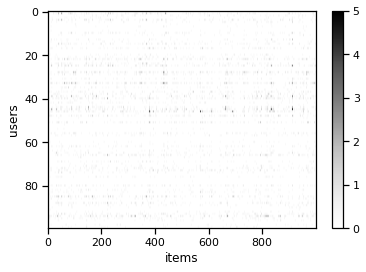

Max data:   tensor(14.)
num zeros:  tensor(95568)
Data shape:  torch.Size([100, 1000])


  0%|          | 0/100 [00:00<?, ?it/s]

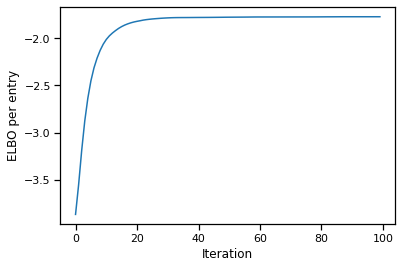

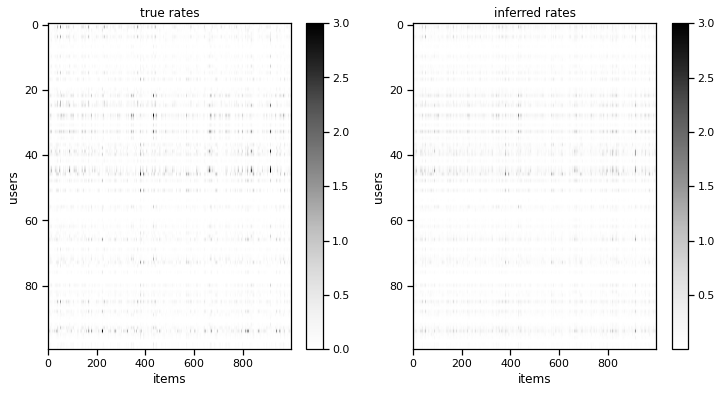

In [ ]:
def test_toy_datset():

    # Constants
    N = 100   # num "users"
    M = 1000 # num "items"
    K = 5     # number of latent factors

    # Hyperparameters
    alpha = 0.1  # sparse gamma prior with mean alpha/beta 
    beta = 1.0

    # Sample data from the model
    torch.manual_seed(305)
    theta = Gamma(alpha, beta).sample(sample_shape=(N, K))
    eta = Gamma(alpha, beta).sample(sample_shape=(M, K))
    data = Poisson(theta @ eta.T).sample()

    print(data.shape)
    # Plot the data matrix
    plt.imshow(data, aspect="auto", vmax=5, cmap="Greys")
    plt.xlabel("items")
    plt.ylabel("users")
    plt.colorbar()
    plt.show()

    print("Max data:  ", data.max())
    print("num zeros: ", torch.sum(data == 0))
    print("Data shape: ", data.shape)

    ### CAVI
    elbos, (q_z, q_theta, q_eta) = cavi(data)

    ### plot ELBOS
    plt.plot(elbos[1:])
    plt.xlabel("Iteration")
    plt.ylabel("ELBO per entry")
    plt.show()

    ### diagnostics
    true_rates = theta @ eta.T
    inf_rates = q_theta.mean @ q_eta.mean.T

    # Plot the data matrix
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(true_rates, aspect="auto", vmax=3, cmap="Greys")
    plt.xlabel("items")
    plt.ylabel("users")
    plt.title("true rates")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(inf_rates, aspect="auto", vmax=3, cmap="Greys")
    plt.xlabel("items")
    plt.ylabel("users")
    plt.title("inferred rates")
    plt.colorbar()
    plt.show()

test_toy_datset()

# Problem 4: Run your code on a downsampled LastFM dataset

Next, we will use data gathered from [Last.FM](www.last.fm) users to fit a PMF model. We use a downsampled version of the [Last.FM-360K users](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html) dataset. This dataset records how many times each user played an artist's songs. We downsample the data to include only the 2000 most popular artists, as measured by how many users listened to the artist at least once, and the 1000 most prolific users, as measured by how many artists they have listened to.

In the code below , we use `lfm` to represent the data matrix $X$ in the model. That is, `lfm[n, d]` denotes how many times the `n`-th user played a song by the `d`-th artist.

In [ ]:
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw5/subsampled_last_fm.csv

--2022-05-02 04:42:50--  https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw5/subsampled_last_fm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1267973 (1.2M) [text/plain]
Saving to: ‘subsampled_last_fm.csv’

subsampled_last_fm. 100%[===================>]   1.21M  --.-KB/s    in 0.05s   

2022-05-02 04:42:50 (23.0 MB/s) - ‘subsampled_last_fm.csv’ saved [1267973/1267973]



In [ ]:
import pandas as pd

lfm_df = pd.read_csv('subsampled_last_fm.csv')
lfm = lfm_df.pivot_table(index='UserID', columns='ItemID', aggfunc=sum)\
    .fillna(0).astype(int).to_numpy()
lfm = torch.tensor(lfm, dtype=torch.int)
print(lfm.shape)

torch.Size([999, 2000])


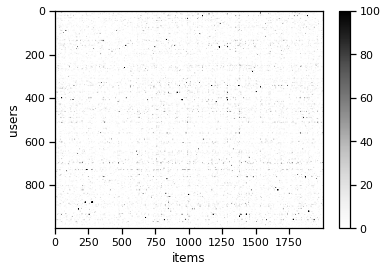

In [ ]:
plt.imshow(lfm, aspect="auto", vmax=100, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.colorbar()

Using the code below, run coordinate ascent variational inference on this dataset. Our implementation takes around 10-15 minutes to finish, and achieves an ELBO of $-1590$.

In [ ]:
elbos, (q_z, q_theta, q_eta) = cavi(lfm, 
     num_factors=40, 
     num_iters=200, 
     alpha_theta=1.,
     beta_theta=0.5,
     alpha_eta=1.,
     beta_eta=0.5)

  0%|          | 0/200 [00:00<?, ?it/s]

tensor(-0.3790)


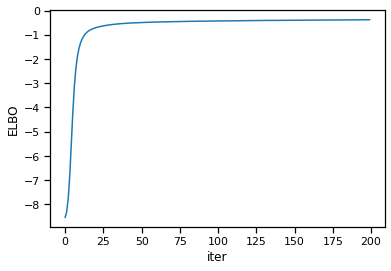

In [ ]:
print(elbos[-1])
plt.plot(elbos[1:])
plt.xlabel("iter")
plt.ylabel("ELBO")
plt.show()

## Investigate "genres"

The columns of $\mathbf{H}$ correspond to weights on artists. Intuitively, each of the $K$ columns should put weight on subsets of artists that are often played together. We might think of these columns as reflecting different "genres" of music. The code below the top 10 artists for a few of these columns. 

In [ ]:
# Find the 10 most used genres
genre_loading = q_theta.mean.sum(0)
genre_order = torch.argsort(genre_loading, descending=True)

# Print the top 10 artists for each of the top 10 genres
for genre in genre_order[:10]:
    print("genre ", genre)
    artist_idx = torch.argsort(q_eta.mean[:, genre], 
                               descending=True)[:10].numpy()
    subset = lfm_df[lfm_df['ItemID'].isin(artist_idx)]
    print(subset[['ItemID', 'Artist']].drop_duplicates())
    print("")
    

genre  tensor(1)
      ItemID          Artist
1       1647  tegan and sara
10        15  sufjan stevens
24        38       cat power
44        28   elliott smith
154     1306    modest mouse
155     1578      ryan adams
157      910     bright eyes
469     1959     fleet foxes
1019     815       sam cooke
1289    1933           jay-z

genre  tensor(7)
     ItemID               Artist
49     1286            radiohead
204     627          david bowie
206     795             the cure
320    1658                 devo
394     476           the smiths
475      12            morrissey
687    1877            new order
711     692          sonic youth
739     813     guided by voices
757     469  the magnetic fields

genre  tensor(25)
       ItemID         Artist
60        990     pink floyd
61        758      metallica
105       773   led zeppelin
142      1591    iron maiden
165       806   judas priest
211       763          ac/dc
1365      614  black sabbath
1369     1301       megadeth
137

## Problem 4a

Inspect the data either using the csv file or the pandas dataframe and choose a user who has listened to artists you recognize. If you are not familiar with any of the artists, use the listener with UserID 349, who mostly listens to hip-hop artists. For the particular user $n$ you choose, find the 10 artists who are predicted to have the most plays by sorting the vector of mean song counts predicted by the model, i.e. the $n^{\text{th}}$ row of $\mathbb{E}_q [\boldsymbol{\Theta} \mathbf{H}^\top ]$. Are these artists you would expect the user would enjoy? Are there any artists that the user has not listened to?

*Hint: Use `torch.argsort(..., descending=True)` to return the indices of the largest elements of a vector in descending order.*


In [ ]:
lfm_df.query("Artist == 'bruce springsteen'").sort_values("Count", ascending=False).head(10)

,UserID,ItemID,Artist,Count
34674,854,848,bruce springsteen,1370
4563,107,848,bruce springsteen,324
2475,57,848,bruce springsteen,304
30416,738,848,bruce springsteen,291
14488,346,848,bruce springsteen,289
26947,654,848,bruce springsteen,264
18180,436,848,bruce springsteen,248
9074,216,848,bruce springsteen,222
23380,563,848,bruce springsteen,219
3956,94,848,bruce springsteen,211


First, the user's actual top plays:

In [ ]:
###
# Your code here.
##

USER_DEMO = 854

lfm_df.query(f"UserID == {USER_DEMO}").sort_values("Count", ascending=False).head(10)

,UserID,ItemID,Artist,Count
34673,854,857,bob dylan,3047
34674,854,848,bruce springsteen,1370
34675,854,1100,the clash,1028
34676,854,1533,tom waits,803
34677,854,836,håkan hellström,699
34678,854,476,the smiths,621
34679,854,479,jens lekman,603
34680,854,795,the cure,576
34681,854,12,morrissey,496
34682,854,1377,the beatles,444


Then the predicted top plays:

In [ ]:
loadings = q_theta.mean[USER_DEMO, :] @ (q_eta.mean.T)
user_t10 = torch.argsort(loadings, descending=True)[0:10].numpy()
disp_df = pd.DataFrame({
    "ItemID": user_t10,
    "user_ranking": np.arange(1, 11)
}).merge(
   lfm_df[lfm_df['ItemID'].\
          isin(user_t10)].\
          groupby("Artist", as_index=False).\
          head(1)[["Artist", "ItemID"]].\
          reset_index(drop=True),
   on=["ItemID"]
)
disp_df

,ItemID,user_ranking,Artist
0,857,1,bob dylan
1,755,2,leonard cohen
2,1533,3,tom waits
3,848,4,bruce springsteen
4,13,5,elvis presley
5,1370,6,the rolling stones
6,163,7,nick cave and the bad seeds
7,163,7,nick cave & the bad seeds
8,1043,8,various artists
9,1043,8,v.a.



**Answer**:

I chose the most prolific Bruce Springsteen user in the dataset (`UserID=854`). For the most part, I expected this user to listen to middle-aged/Dad rock, i.e. Springsteen, Tom Petty, the Who, the Eagles, the Rolling Stones, that kind of thing. Further, given the apparent naming discrepancies -- for instance, `nick cave & the bad seeds` and `nick cave and the bad seeds` are treated as separate artists -- I expected some duplicate `bruce springsteen & the e-street band` or `bruce springsteen and the e-street band` entries. 

As it turned out, results were generally in the middle-aged/Dad rock genre: Springsteen and the Rolling stones were in the top 10. More singer-songwriter-y types such as Bob Dylan, Johnny Cash, and Tom Waits were also included -- while this was a tad surprising (I'd have bet more on the bands named above), it's not entirely non-sensical, given some of Springsteen's later songs. Additionally, I was surprised to see the inclusion of Elvis and Miles Davis -- would never have guessed those two. And I'd assume various artists/va would include a number of hits from that era of rock.

So overall, the modeled rankings didn't match my expectations at the outset, but generally I found them coherent and plausible. 

# Problem 5: Reflections

## Problem 5a

Discuss one advantage and one disadvantage of fitting a posterior using variational inference vs. sampling from the posterior using MCMC.

---

*   Advantage: VI methods may be more computationally tractable here. For example, if we did HMC or Metropolis sampling, the chain could take days if not weeks to converge. Here, we get a quick and workable solution within minutes, and not having to supervise an MCMC chain may be a big plus. 

*   Disadvantage: We may not get the exact, or even a convergent, solution. Whereas MCMC is guaranteed to converge into infinity, there are no such guarantees with VI/ELBO methods. In fact, we may find ourselves stuck in a local minima, or in more general VI settings (e.g. VAEs) fail to achieve tight ELBO bounds. So the gain in computational viability may come at the expense of model accuracy.



*Your answer here.*

---

## Problem 5b

First, explain why the assumption that $\mathbf{Z}, \mathbf{H}$ and $\boldsymbol{\Theta}$ are independent in the posterior will never hold. 

Next, recall that maximizing the ELBO is equivalent to minimizing the KL divergence between the approximate posterior and the true posterior. In general, how will the approximate posterior differ from the true posterior, given that the variational family does not include the true posterior?

---

As set forth in our calculations for $\log p(\Theta | Z, H)$, we have that sub-count is explicitly dependent on $Z, H$, in violation of the assumption above. However, it may be a situation where we can get "good enough" results despite the violation of such an assumption. 

In general, the approximate posterior will probably have a smaller variance than the true posterior. This is particularly true when approximating via a normal distribution, which: i.) is comparatively thinly-tailed (unlike a T, for instance) and ii.) especially true when the true posterior is outside the variational family. As but one example here, consider a multimodal setting. Recall here that our minimization problem w.r.t. the latent $Z$ is of the form 
\begin{align}
ELBO(q; x, z, p)
&=
E_{z\sim q}[\log p(x, z;\theta) - \log q(z;\theta)] \\
&= p(x;\theta) - D_{KL}(q(z;\theta) || p(z|x;\theta)) \\
&= E_{z\sim q}[\log (p(x| z)p(z)) - \log q(z;\theta)] \\
&= E_{z\sim q}[\log (p(x| z;\theta)] + E_{z\sim q}[p(z;\theta) - \log q(z;\theta)] \\
&= E_{z\sim q}[\log (p(x| z;\theta)] -D_{KL}(q(z;\theta)||p(z;\theta))
\end{align}

In maximizing this, we have a two-way struggle: first, we aim to maximize $E_{z\sim q}[\log (p(x| z;\theta)]$, which would happen if we had $q$ such that it put unit mass on the MAP of $p(x|z;\theta)$. Second, we also need $q$ to stay reasonably close to $p$ (governed by the $D_{KL}(q(z;\theta)||p(z;\theta))$), lest the KL divergence term blow things up. 

Hence, in multimodal setting, the variational approximation will attach itself to one of the modes, since sitting in between will incur a $p(x|z; \theta)$ that is tiny (ruining maximization), and it will incur some least worst cost for the KL distance between $q$ and $p$; that is, it will choose a lesser of the evils and just pick a mode. In turn, it's variance will form around that mode, meaning it will fail to capture the variance of the other modes, and hence underestimate variance in general.


---

## Problem 5c

Suppose we are using this model to recommend new items to users. Describe one improvement that could be made to the model which you think would lead to better recommendations.

---

First, as noted above, some data wrangling may be necessary: we'll want to condense down the duplicate columns such as `v.a.` and `various artists` or `nick cave and the bad seeds` and `nick cave & the bad seeds`. This will allow us to fit on a better/more accurate dataset. Moreover, we may want to set up a tuning/CV procedure so we can better select priors and/or select an ideal value of `K`. Lastly, we may want to explore adding additional hierarchical components/features, to give us some way to correct for the fact that user preferences may change when/where they're listening to the music. For instance, someone's workout playlist may be different from their roadtrip playlist, and if we could embed workout/roadtrip proxy features, we may be able to better account/correct for seemingly disparate preferences.


---

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw5_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 

In [ ]:
from torch.distributions import Uniform
data = X

alpha_theta=0.1
beta_theta=1.0
alpha_eta=0.1
beta_eta=1.0



data = data.float()
N, M = data.shape
K = 5      # short hand

# Initialize the variational posteriors.
q_eta = Gamma(Uniform(0.5 * alpha_eta, 1.5 * alpha_eta).sample((M, K)),
              Uniform(0.5 * beta_eta, 1.5 * beta_eta).sample((M, K)))
q_theta = Gamma(Uniform(0.5 * alpha_theta, 1.5 * alpha_theta).sample((N, K)),
                Uniform(0.5 * beta_theta, 1.5 * beta_theta).sample((N, K)))
q_z = BatchedMultinomial(data, logits=torch.zeros((N, M, K)))